In [1]:
import pydicom
import numpy as np
import cv2
import os
import json
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import torch
from torchvision import models
import pandas as pd


class DICOMPreprocessor:
    def __init__(
        self,
        target_size=None,
        window_center=None,
        window_width=None,
        normalize=True,
        to_three_channels=False,
    ):
        self.target_size = target_size
        self.window_center = window_center
        self.window_width = window_width
        self.normalize = normalize
        self.to_three_channels = to_three_channels

    def load_dicom(self, dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)
        return dicom_data.pixel_array.astype(np.float32)

    def apply_windowing(self, image):
        if self.window_center is not None and self.window_width is not None:
            min_value = self.window_center - self.window_width // 2
            max_value = self.window_center + self.window_width // 2
            image = np.clip(image, min_value, max_value)
            image = (image - min_value) / (max_value - min_value)
        return image

    def resize_image(self, image):
        if self.target_size is not None:
            return cv2.resize(
                image,
                (self.target_size, self.target_size),
                interpolation=cv2.INTER_LINEAR,
            )
        return image

    def pad_or_crop(self, image):
        if self.target_size is not None:
            current_size = image.shape[0]  # Assuming square images
            if current_size < self.target_size:
                pad_amount = (self.target_size - current_size) // 2
                image = np.pad(
                    image,
                    ((pad_amount, pad_amount), (pad_amount, pad_amount)),
                    mode="constant",
                )
            elif current_size > self.target_size:
                start = (current_size - self.target_size) // 2
                image = image[
                    start : start + self.target_size, start : start + self.target_size
                ]
        return image

    def normalize_image(self, image):
        if self.normalize:
            min_val = np.min(image)
            max_val = np.max(image)
            return (
                (image - min_val) / (max_val - min_val) if max_val > min_val else image
            )
        return image

    def convert_to_three_channels(self, image):
        if self.to_three_channels and image.ndim < 3:
            return np.stack((image,) * 3, axis=-1)
        return image

    def preprocess(self, dicom_path):
        image = self.load_dicom(dicom_path)
        image = self.apply_windowing(image)
        image = self.normalize_image(image)
        image = self.resize_image(image)
        image = self.pad_or_crop(image)
        image = self.convert_to_three_channels(image)
        return image


class RadImageNet:
    def __init__(self, model_path: str) -> None:
        self.model_path = model_path
        self.model = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._load_model()

    def _load_model(self) -> None:
        if "DenseNet121" in self.model_path:
            self.model = models.densenet121(weights=None)
        elif "InceptionV3" in self.model_path:
            self.model = models.inception_v3(weights=None)
        elif "ResNet50" in self.model_path:
            self.model = models.resnet50(weights=None)
        else:
            raise ValueError(
                "Model not recognized. Ensure the model path contains one of 'DenseNet121', 'InceptionV3', or 'ResNet50'."
            )

        state_dict = torch.load(self.model_path, map_location=self.device)
        self.model.load_state_dict(state_dict, strict=False)
        self.model.to(self.device)  # Move model to the appropriate device (GPU or CPU)
        self.model.eval()  # Set to evaluation mode

    def load_model_and_predict(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # Check input dimensions
        if self.model is None:
            raise ValueError("Model is not loaded.")
        if len(input_tensor.shape) != 4:
            raise ValueError(
                "Input tensor must be of shape [slices, 3, 224 or 299, 224 or 299]."
            )

        # Handle input size for InceptionV3
        if isinstance(self.model, models.Inception3):
            if input_tensor.shape[2:] != (299, 299):
                raise ValueError(
                    "InceptionV3 model requires input size of [slices, 3, 299, 299]."
                )
        else:
            if input_tensor.shape[2:] != (224, 224):
                raise ValueError(
                    "DenseNet121 and ResNet50 models require input size of [slices, 3, 224, 224]."
                )

        # Move input tensor to the same device as the model
        input_tensor = input_tensor.to(self.device)

        # Forward pass to generate embeddings
        with torch.no_grad():
            feature_emb = self.model(input_tensor)

        return feature_emb


radimagenet = RadImageNet("/mnt/d/Models/radimage/DenseNet121.pt")

In [ ]:
# Separate function for multiprocessing
def process_dicom_file(dicom_path, preprocessor_args):
    preprocessor = DICOMPreprocessor(**preprocessor_args)
    return preprocessor.preprocess(dicom_path)


def get_dicom_folder(folder_path):
    dicom_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".dcm"):
                file_path = os.path.join(root, file)
                dicom_paths.append(file_path)
    return dicom_paths


def process_patient(patient, preprocessor_args):
    patient_data = []
    for modality in RADIOLOGY_MODALITIES:
        if modality in patient:
            for entry in patient[modality]:
                folder_path = f"/mnt/d/TCGA/raw/TCGA-LUAD/raw/{patient.get('PatientID')}/{modality}/{entry.get('SeriesInstanceUID')}/{entry.get('SeriesInstanceUID')}"
                dicom_paths = get_dicom_folder(folder_path)

                if dicom_paths:
                    # Using ProcessPoolExecutor for multiprocessing
                    with ProcessPoolExecutor() as executor:
                        volume = list(
                            executor.map(
                                process_dicom_file,
                                dicom_paths,
                                [preprocessor_args] * len(dicom_paths),
                            )
                        )

                    # Filtering out any failed processes (returns None in case of an error)
                    volume = [v for v in volume if v is not None]

                    if volume:  # Ensure there's data before storing
                        volume_np = np.array(volume)

                        # Check if volume_np has at least 4 dimensions before transposing
                        if volume_np.ndim == 4 and volume_np.shape[3] in [
                            1,
                            3,
                        ]:  # Expecting (slices, height, width, channels)
                            slices = (
                                torch.from_numpy(volume_np.transpose(0, 3, 1, 2))
                                .float()
                                .cuda()
                            )
                            embedding = (
                                radimagenet.load_model_and_predict(slices).cpu().numpy()
                            )

                            # Serialize the arrays to byte strings
                            patient_data.append(
                                {
                                    "PatientID": patient.get("PatientID"),
                                    "Modality": modality,
                                    "SeriesInstanceUID": entry.get("SeriesInstanceUID"),
                                    "Slices": volume_np.tobytes(),  # Serialize slices
                                    "Embeddings": embedding.tobytes(),  # Serialize embeddings
                                    "EmbeddingShape": embedding.shape,  # Keep the shape for deserialization
                                }
                            )
                        else:
                            print(
                                f"Skipping {entry.get('SeriesInstanceUID')} due to incompatible volume shape: {volume_np.shape}"
                            )
    return patient_data


# Load and filter manifest
with open("/mnt/d/TCGA/raw/TCGA-LUAD/manifest.json") as f:
    manifest = json.load(f)

RADIOLOGY_MODALITIES = ["PT", "CT", "NM"]
KEYS_TO_KEEP = ["PatientID", "gdc_case_id", "PT", "CT", "NM"]

filtered_manifest = [
    {
        k: v
        for k, v in patient.items()
        if k in KEYS_TO_KEEP and any(mod in patient for mod in RADIOLOGY_MODALITIES)
    }
    for patient in manifest
]
filtered_manifest = [patient for patient in filtered_manifest if len(patient) > 1]

preprocessor_args = {
    "target_size": 224,
    "normalize": True,
    "to_three_channels": True,
}

# Limit to 10 patients
filtered_manifest = filtered_manifest[:5]

# Initialize a list to hold all the patient data
all_patient_data = []
# Process patients
for patient in tqdm(filtered_manifest, desc="Processing Patients", leave=False):
    patient_data = process_patient(patient, preprocessor_args)
    all_patient_data.extend(patient_data)

# Convert the data into a Pandas DataFrame
patient_df = pd.DataFrame(all_patient_data)

# Save DataFrame to Parquet file
output_file = "/mnt/f/Projects/HoneyBee/rad/Radiology (RadImageNet).parquet"
patient_df.to_parquet(output_file, engine="pyarrow")

print(f"Data saved to {output_file}")

Modality: CT, SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7777.9002.193487924462588960549189071833, Slices: (1, 224, 224)


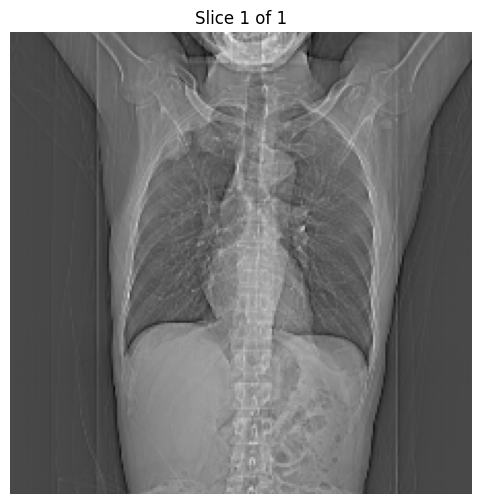

Modality: CT, SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7777.9002.144528617248654843333500404696, Slices: (23, 224, 224)


interactive(children=(IntSlider(value=11, description='slice_idx', max=22), Output()), _dom_classes=('widget-i…

Modality: CT, SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240, Slices: (24, 224, 224)


interactive(children=(IntSlider(value=11, description='slice_idx', max=23), Output()), _dom_classes=('widget-i…

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Load the parquet file and filter for the desired patient
output_file = "/mnt/f/Projects/HoneyBee/rad/Radiology (RadImageNet).parquet"
df = pd.read_parquet(output_file, engine="pyarrow")

# Patient details
patient_id = "TCGA-17-Z038"
patient_data = df[df["PatientID"] == patient_id]
# patient_data = patient_data.iloc[1:2]

# Iterate through selected slices
for i, row in patient_data.iterrows():
    slices = np.frombuffer(row["Slices"], dtype=np.float32)
    slices = slices.reshape(row["EmbeddingShape"][0], 224, 224, 3)
    slices = slices[:, :, :, 0]  # Use only one channel for grayscale visualization

    print(f"Modality: {row['Modality']}, SeriesInstanceUID: {row['SeriesInstanceUID']}, Slices: {slices.shape}")

    def show_slice(slice_idx):
        """
        Function to display a specific slice based on the slider's value.
        """
        plt.figure(figsize=(6, 6))
        plt.imshow(slices[slice_idx], cmap="gray")
        plt.title(f"Slice {slice_idx + 1} of {slices.shape[0]}")
        plt.axis("off")
        plt.show()

    # Create an interactive slider to select slices
    if slices.shape[0] > 1:
        interact(show_slice, slice_idx=(0, slices.shape[0] - 1))
    else:
        # For a single slice, directly display it
        show_slice(0)
